# Projet SVM : Efficacité d'un attaquant

### Importation des librairies

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
#Modélisation 
#Classifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC 
from sklearn.linear_model import SGDClassifier , LogisticRegression
#Multiclass strategie
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
#Regressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
#Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#Eval
from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV
from sklearn_evaluation import plot

There's a new sklearn-evaluation version available (0.11.1), you're running 0.11.0. To upgrade: pip install sklearn-evaluation --upgrade


### Importation des jeux de données

In [2]:
df_apparitions = pd.read_csv("C:/Users/arthu/OneDrive/Documents/M2 ECAP/SVM et réseaux de neurones/appearances.csv")
df_joueurs = pd.read_csv("C:/Users/arthu/OneDrive/Documents/M2 ECAP/SVM et réseaux de neurones/players.csv")
df_valeurs = pd.read_csv("C:/Users/arthu/OneDrive/Documents/M2 ECAP/SVM et réseaux de neurones/player_valuations.csv")
df_competitions = pd.read_csv("C:/Users/arthu/OneDrive/Documents/M2 ECAP/SVM et réseaux de neurones/competitions.csv")
df_match = pd.read_csv("C:/Users/arthu/OneDrive/Documents/M2 ECAP/SVM et réseaux de neurones/game_events.csv")


### Visualisation des jeux de données

In [3]:
df_joueurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23711 entries, 0 to 23710
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_id                    23711 non-null  int64  
 1   last_season                  23711 non-null  int64  
 2   current_club_id              23711 non-null  int64  
 3   name                         23711 non-null  object 
 4   pretty_name                  23711 non-null  object 
 5   country_of_birth             22292 non-null  object 
 6   country_of_citizenship       23710 non-null  object 
 7   date_of_birth                23689 non-null  object 
 8   position                     23711 non-null  object 
 9   sub_position                 23711 non-null  object 
 10  foot                         22051 non-null  object 
 11  height_in_cm                 23711 non-null  int64  
 12  market_value_in_gbp          16842 non-null  float64
 13  highest_market_v

In [4]:
df_apparitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041848 entries, 0 to 1041847
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   player_id       1041848 non-null  int64  
 1   game_id         1041837 non-null  float64
 2   appearance_id   1041848 non-null  object 
 3   competition_id  1041848 non-null  object 
 4   player_club_id  1041848 non-null  int64  
 5   goals           1041848 non-null  int64  
 6   assists         1041848 non-null  int64  
 7   minutes_played  1041848 non-null  int64  
 8   yellow_cards    1041848 non-null  int64  
 9   red_cards       1041848 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 71.5+ MB


In [5]:
df_apparitions.competition_id.describe()

count     1041848
unique         42
top           IT1
freq        86802
Name: competition_id, dtype: object

In [6]:
df_apparitions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041848 entries, 0 to 1041847
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   player_id       1041848 non-null  int64  
 1   game_id         1041837 non-null  float64
 2   appearance_id   1041848 non-null  object 
 3   competition_id  1041848 non-null  object 
 4   player_club_id  1041848 non-null  int64  
 5   goals           1041848 non-null  int64  
 6   assists         1041848 non-null  int64  
 7   minutes_played  1041848 non-null  int64  
 8   yellow_cards    1041848 non-null  int64  
 9   red_cards       1041848 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 71.5+ MB


### On regroupe les tables en fonction de l'id des joueurs

In [7]:

df = df_apparitions.merge(df_joueurs, on=['player_id'])

df = df.groupby('player_id').agg(lambda col: np.sort(col.unique()).tolist())

In [8]:
df.head()

,game_id,appearance_id,competition_id,player_club_id,goals,assists,minutes_played,yellow_cards,red_cards,last_season,...,country_of_birth,country_of_citizenship,date_of_birth,position,sub_position,foot,height_in_cm,market_value_in_gbp,highest_market_value_in_gbp,url
player_id,,,,,,,,,,,,,,,,,,,,,
10,"[2478592.0, 2478604.0, 2478624.0, 2478642.0, 2...","[2478592_10, 2478604_10, 2478624_10, 2478642_1...","[CIT, CLQ, EL, IT1, SCI]",[398],"[0, 1, 2]","[0, 1, 2]","[1, 4, 5, 7, 10, 13, 14, 15, 20, 21, 24, 25, 2...","[0, 1]",[0],[2015],...,[Poland],[Germany],[1978-06-09],[Attack],[attack - Centre-Forward],[Right],[184],[nan],[27000000.0],[https://www.transfermarkt.co.uk/miroslav-klos...
26,"[2460639.0, 2460645.0, 2460655.0, 2460663.0, 2...","[2460639_26, 2460645_26, 2460655_26, 2460663_2...","[CL, DFB, EL, ELQ, L1]",[16],[0],[0],"[1, 90, 120]","[0, 1]",[0],[2017],...,[Germany],[Germany],[1980-08-06],[Goalkeeper],[Goalkeeper],[Left],[190],[nan],[7200000.0],[https://www.transfermarkt.co.uk/roman-weidenf...
65,"[2482114.0, 2482115.0, 2482131.0, 2482141.0, 2...","[2482114_65, 2482115_65, 2482131_65, 2482141_6...","[CL, EL, FR1, GR1, GRP]","[162, 1091]","[0, 1, 2]","[0, 1]","[4, 14, 17, 19, 20, 21, 22, 24, 27, 29, 30, 31...","[0, 1]","[0, 1]",[2015],...,[Bulgaria],[Bulgaria],[1981-01-30],[Attack],[attack - Centre-Forward],[nan],[0],[nan],[31050000.0],[https://www.transfermarkt.co.uk/dimitar-berba...
80,"[2704677.0, 2704703.0, 2704704.0, 2871908.0, 2...","[2704677_80, 2704703_80, 2704704_80, 2871908_8...",[L1],[27],[0],[0],[90],[0],[0],[2017],...,[DDR],[Germany],[1981-03-18],[Goalkeeper],[Goalkeeper],[Right],[194],[nan],[2700000.0],[https://www.transfermarkt.co.uk/tom-starke/pr...
132,"[2458586.0, 2483328.0, 2486510.0, 2486537.0, 2...","[2458586_132, 2483328_132, 2486510_132, 248653...","[CGB, CL, CLQ, GB1, GBCS]",[11],"[0, 1]","[0, 1]","[1, 7, 8, 9, 12, 14, 19, 20, 22, 24, 83, 87, 90]","[0, 1]",[0],[2015],...,[CSSR],[Czech Republic],[1980-10-04],[Attack],[midfield - Attacking Midfield],[nan],[0],[nan],[15750000.0],[https://www.transfermarkt.co.uk/tomas-rosicky...


#### Création de fonctions afin de mettre en place notre indicateur

In [9]:
def combine_stats(x,y):
    return x+y
def efficacity(x,y):
    return x/y
def aggregate(x):
    return sum(x)
def name(x):
    return x[0]


In [10]:
df['minutes totales jouées']=df['minutes_played'].apply(aggregate)
df['buts']=df['goals'].apply(aggregate)
df['passes décisives']=df['assists'].apply(aggregate)
df['pied']=df['foot'].apply(name)
df['poste']=df['position'].apply(name)
df['championnat']=df['competition_id'].apply(name)
df['valeur_marchande']=df['highest_market_value_in_gbp'].apply(name)
df['taille']=df['height_in_cm'].apply(name)



# colonnes à garder
target=['nom', 'date_of_birth', 'position','minutes totales jouées','buts','passes décisives','taille','championnat','pied','poste','valeur_marchande']

# suppression des autres colonnes
for item in df.columns:
    if item not in target:
        del df[item]

df.head(20)

,date_of_birth,position,minutes totales jouées,buts,passes décisives,pied,poste,championnat,valeur_marchande,taille
player_id,,,,,,,,,,
10,[1978-06-09],[Attack],1799,3,3,Right,Attack,CIT,27000000.0,184
26,[1980-08-06],[Goalkeeper],211,0,0,Left,Goalkeeper,CL,7200000.0,190
65,[1981-01-30],[Attack],1553,3,1,NaN,Attack,CL,31050000.0,0
80,[1981-03-18],[Goalkeeper],90,0,0,Right,Goalkeeper,L1,2700000.0,194
132,[1980-10-04],[Attack],396,1,1,NaN,Attack,CGB,15750000.0,0
215,[1981-08-16],[Attack],551,3,1,Right,Attack,CDR,10800000.0,193
410,[1980-02-13],[Midfield],486,1,1,Left,Midfield,CL,8100000.0,187
488,[1978-11-16],[Goalkeeper],109,0,0,NaN,Goalkeeper,CGB,1980000.0,0
532,[1978-10-03],[Attack],1885,6,1,Right,Attack,CL,10800000.0,184


### Correction des valeurs manquantes

In [11]:
df.championnat.describe()

count     17572
unique       31
top         BE1
freq       1604
Name: championnat, dtype: object

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17572 entries, 10 to 987700
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_of_birth           17572 non-null  object 
 1   position                17572 non-null  object 
 2   minutes totales jouées  17572 non-null  int64  
 3   buts                    17572 non-null  int64  
 4   passes décisives        17572 non-null  int64  
 5   pied                    16865 non-null  object 
 6   poste                   17572 non-null  object 
 7   championnat             17572 non-null  object 
 8   valeur_marchande        17431 non-null  float64
 9   taille                  17572 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 1.1+ MB


#### On supprime les obseravtions manquantes a savoir pour la variable pied et valeur_marchande

In [13]:
df=df[df.valeur_marchande.isnull()==False]

In [14]:
df=df[df.pied.isnull()==False]

In [15]:
df=df.sort_values('taille')
df.head(20)

,date_of_birth,position,minutes totales jouées,buts,passes décisives,pied,poste,championnat,valeur_marchande,taille
player_id,,,,,,,,,,
542842,[1998-05-27],[Midfield],399,0,0,Right,Midfield,DK1,270000.0,0
554198,[2002-03-08],[Defender],23,0,0,Left,Defender,DKP,45000.0,0
748506,[2004-04-07],[Defender],332,0,1,Right,Defender,BE1,630000.0,0
558244,[2001-04-07],[Midfield],55,0,0,Right,Midfield,CLQ,270000.0,0
561613,[2001-05-04],[Goalkeeper],107,0,0,Right,Goalkeeper,CDR,360000.0,0
745200,[2002-02-25],[Attack],30,0,0,Left,Attack,FR1,900000.0,0
565434,[2003-08-03],[Attack],154,0,1,Right,Attack,BE1,180000.0,0
333684,[1995-03-07],[Attack],67,0,0,Left,Attack,DK1,45000.0,0
566571,[2001-06-15],[Defender],593,1,1,Left,Defender,DK1,360000.0,0


#### Suppresion des individus atypiques n'ayant pas de taille

In [16]:
df.drop(df[df['taille'] < 100].index, inplace=True)

In [17]:
df=df.sort_values('valeur_marchande')
df.head(20)

,date_of_birth,position,minutes totales jouées,buts,passes décisives,pied,poste,championnat,valeur_marchande,taille
player_id,,,,,,,,,,
581890,[1999-03-18],[Goalkeeper],90,0,0,Right,Goalkeeper,CGB,23000.0,198
349733,[1996-04-20],[Attack],10,0,0,Right,Attack,TR1,23000.0,175
345758,[1999-01-24],[Midfield],324,0,1,Right,Midfield,SC1,23000.0,180
612024,[2001-02-10],[Midfield],26,0,0,Right,Midfield,NLP,23000.0,181
677937,[2001-03-22],[Defender],16,0,0,Right,Defender,SFA,23000.0,167
674809,[2002-11-12],[Midfield],312,1,0,Right,Midfield,SC1,23000.0,175
214258,[1996-03-31],[Defender],90,0,0,Right,Defender,RU1,23000.0,179
778540,[2001-04-12],[Attack],47,0,0,Left,Attack,NL1,23000.0,185
279614,[1995-03-07],[Defender],210,0,0,Right,Defender,SFA,23000.0,193


## Création de la variable d'efficacité

#### Afin de mesurer l'efficacité d'un attaquant, il est nécessaire de calculer son ratio de buts en fonction de son temps de jeu. Afin de ne pas avoir de valeurs manquantes nous ne prendrons en compte seulement les joueurs ayant été au moins une fois buteur

In [18]:
df.drop(df[df['buts'] <1].index, inplace=True)

In [19]:
df['ratio buts/minute']=efficacity(df['minutes totales jouées'],df['buts'])
df=df.sort_values('ratio buts/minute')
df.head(10)

,date_of_birth,position,minutes totales jouées,buts,passes décisives,pied,poste,championnat,valeur_marchande,taille,ratio buts/minute
player_id,,,,,,,,,,,
493674,[2001-10-24],[Attack],8,1,0,Right,Attack,FR1,900000.0,174,8.0
569488,[2000-11-03],[Attack],13,1,0,Both,Attack,GRP,180000.0,172,13.0
398728,[1996-03-21],[Defender],13,1,0,Right,Defender,RUP,113000.0,179,13.0
624751,[2002-10-10],[Midfield],15,1,0,Right,Midfield,SFA,45000.0,180,15.0
508639,[2003-06-13],[Attack],15,1,0,Right,Attack,NLP,5400000.0,168,15.0
578459,[2002-04-04],[Attack],16,1,0,Right,Attack,NL1,225000.0,184,16.0
395519,[1999-04-02],[Attack],16,1,0,Left,Attack,FR1,450000.0,182,16.0
546415,[2002-11-09],[Attack],17,1,0,Right,Attack,BE1,450000.0,187,17.0
401717,[1998-09-17],[Attack],18,1,0,Right,Attack,DFB,675000.0,176,18.0


#### du fait que certains joueurs ont très peu de temps jeu, nous allons arbitrairement prendre les joueurs avec plus de 500 minutes de jeu afin d'avoir un échantillon représentatif

In [20]:
df.drop(df[df['minutes totales jouées'] < 500.0].index, inplace=True)

#### Avant d'aller plus loins nous allons écrémer la base de données en ne sélectionnant que les attaquants

In [21]:
df.poste.describe()

count       7893
unique         3
top       Attack
freq        3659
Name: poste, dtype: object

#### le jeu de données comprend 6300 attaquants nous allons tout d'abord étudier la comparaison de buts marqués selon le poste

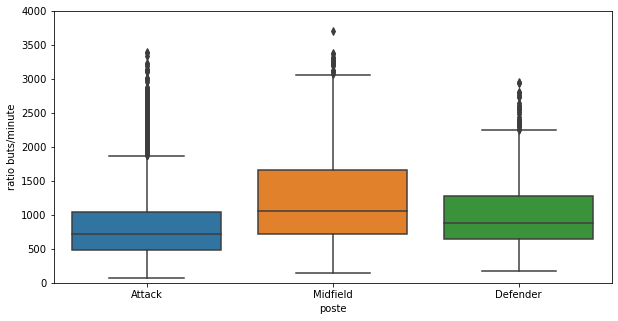

In [22]:
données = pd.concat([df['ratio buts/minute'], df['poste']], axis=1)
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x="poste", y="ratio buts/minute", data=données)
fig.axis(ymin=0, ymax=4000);

#### On remarque logiquement que les attaquants ont un ratio plus faible, on remarque tout de meme que les défenseurs marquent en moyenne plus de buts que les milieux de terrains ce qui est surprenant, cela peut etre due a la construction de la base de donnée

In [23]:
df=df[df['poste']=='Attack']

In [24]:

df.head()

,date_of_birth,position,minutes totales jouées,buts,passes décisives,pied,poste,championnat,valeur_marchande,taille,ratio buts/minute
player_id,,,,,,,,,,,
339314,[1996-07-19],[Attack],754,10,3,Right,Attack,BE1,7200000.0,178,75.400000
209583,[1995-08-01],[Attack],532,6,1,Left,Attack,CGB,900000.0,178,88.666667
85602,[1981-04-01],[Attack],598,6,1,Right,Attack,PO1,450000.0,179,99.666667
70280,[1991-02-20],[Attack],623,6,1,Right,Attack,NL1,2700000.0,193,103.833333
28003,[1987-06-24],[Attack],1043,10,6,Left,Attack,CDR,162000000.0,170,104.300000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3659 entries, 339314 to 33639
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_of_birth           3659 non-null   object 
 1   position                3659 non-null   object 
 2   minutes totales jouées  3659 non-null   int64  
 3   buts                    3659 non-null   int64  
 4   passes décisives        3659 non-null   int64  
 5   pied                    3659 non-null   object 
 6   poste                   3659 non-null   object 
 7   championnat             3659 non-null   object 
 8   valeur_marchande        3659 non-null   float64
 9   taille                  3659 non-null   int64  
 10  ratio buts/minute       3659 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 271.6+ KB


<AxesSubplot:xlabel='championnat', ylabel='ratio buts/minute'>

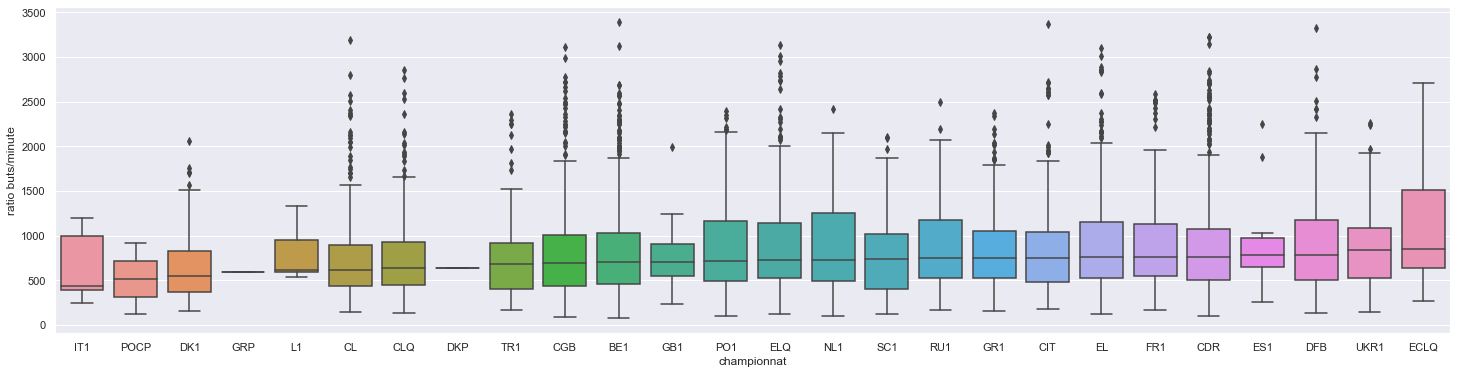

In [26]:
grouped = df.loc[:,['championnat', 'ratio buts/minute']] \
    .groupby(['championnat']) \
    .median() \
    .sort_values(by='ratio buts/minute', ascending=True)

sns.set(rc={'figure.figsize':(25,6)})
sns.boxplot(x=df.championnat, y=df['ratio buts/minute'], order=grouped.index)

#### On ne remarque pas forcément de championnat ayant des attaquants marquant plus souvent.
#### On peut tout de même remarquer que les attaquants italiens ont une médiane relativement plus basse

<AxesSubplot:xlabel='championnat', ylabel='valeur_marchande'>

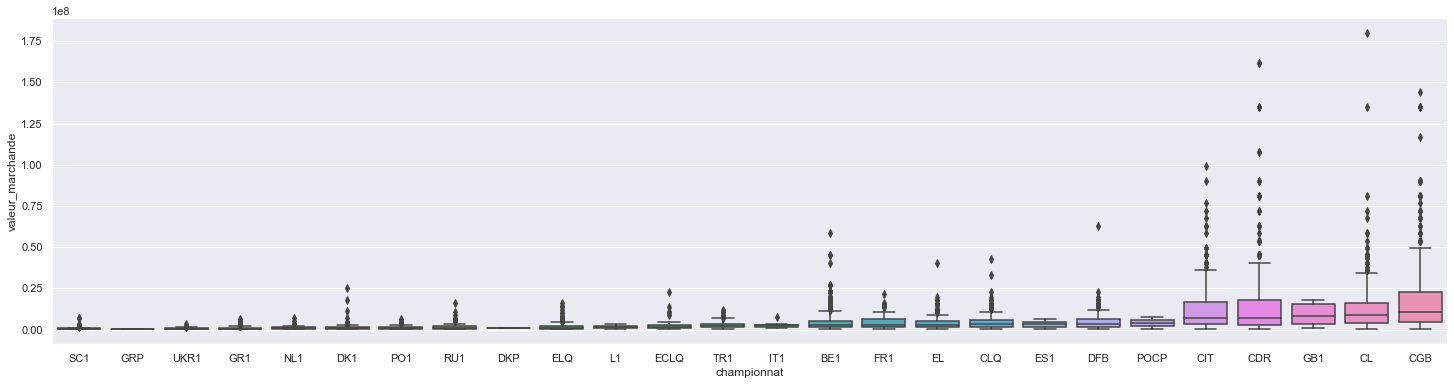

In [27]:
grouped = df.loc[:,['championnat', 'valeur_marchande']] \
    .groupby(['championnat']) \
    .median() \
    .sort_values(by='valeur_marchande', ascending=True)

sns.set(rc={'figure.figsize':(25,6)})
sns.boxplot(x=df.championnat, y=df['valeur_marchande'], order=grouped.index)

### Ici, on peut voir que les joueurs ayant la valeur marchande la plus élevée jouent en champions league(CL) en premier league anglaise (CGB) ou encore en Espagne(CDR)
### Ceci semble logique car ces compétitions regroupent les meilleurs joueurs et donc les meilleurs buteurs

C:\Users\arthu\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ratio buts/minute', ylabel='Density'>

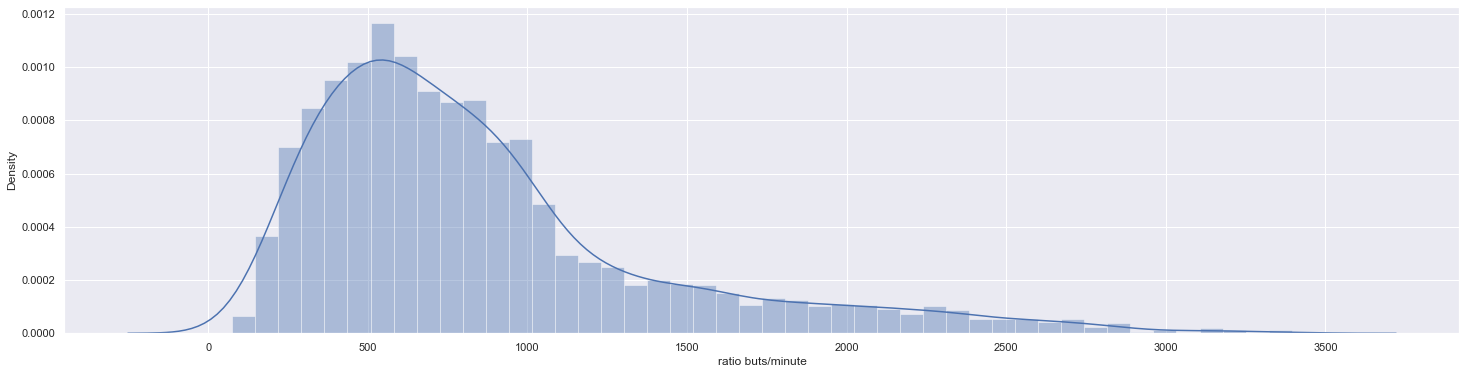

In [28]:

sns.distplot(df['ratio buts/minute'])

### La distribution semble légèrement allongée vers la droite, il peut etre nécessaire de corriger l'atypicité de certains individus ayant peu d'efficacité

<AxesSubplot:>

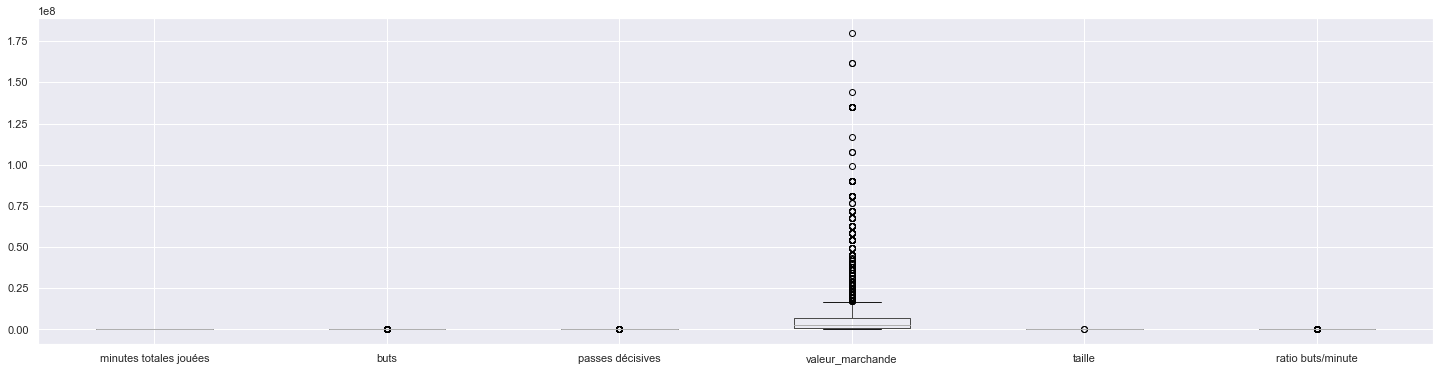

In [29]:
df.boxplot()

C:\Users\arthu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ratio buts/minute'>

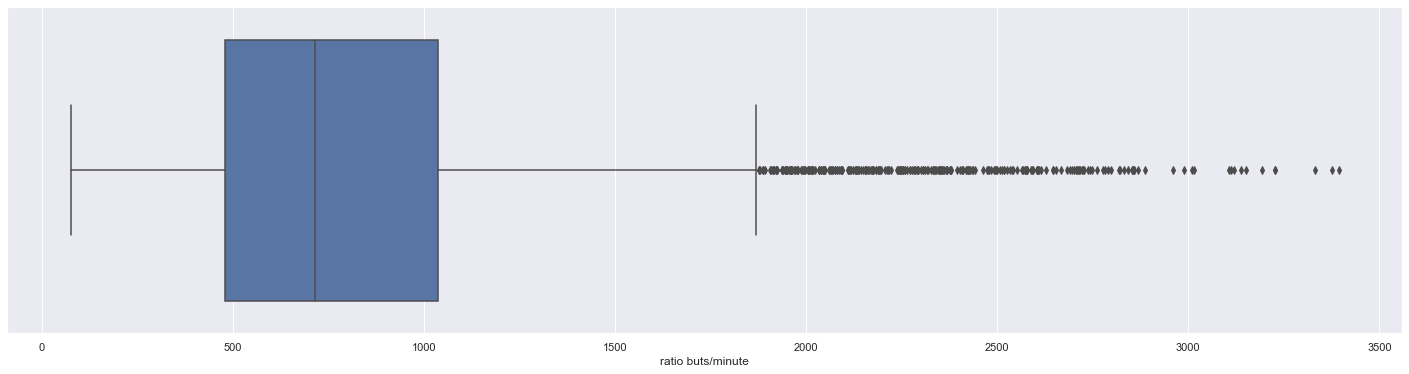

In [30]:
sns.boxplot(df['ratio buts/minute'])


## Visualisation des corrélations
### Ceci va nous permettre de sélectionner les variables les plus influentes

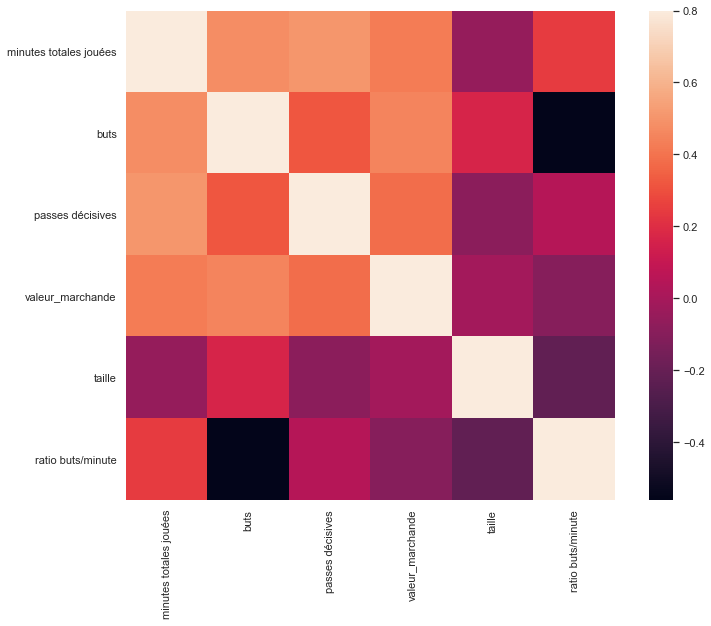

In [31]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

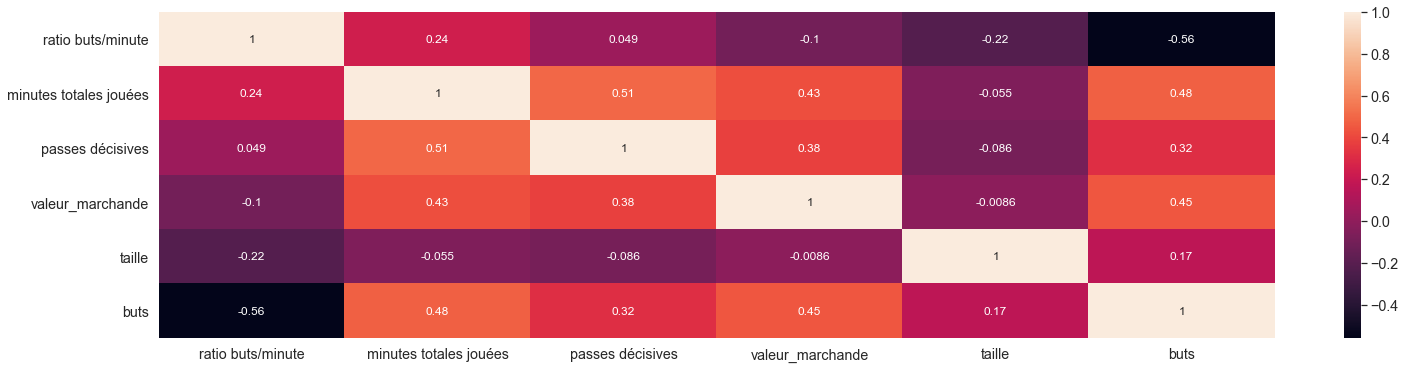

In [32]:
k = 10 
cols = corrmat.nlargest(k,'ratio buts/minute')['ratio buts/minute'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.3)
hm = sns.heatmap(cm, annot=True,annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


## Nuage de points avec les variables les plus influentes

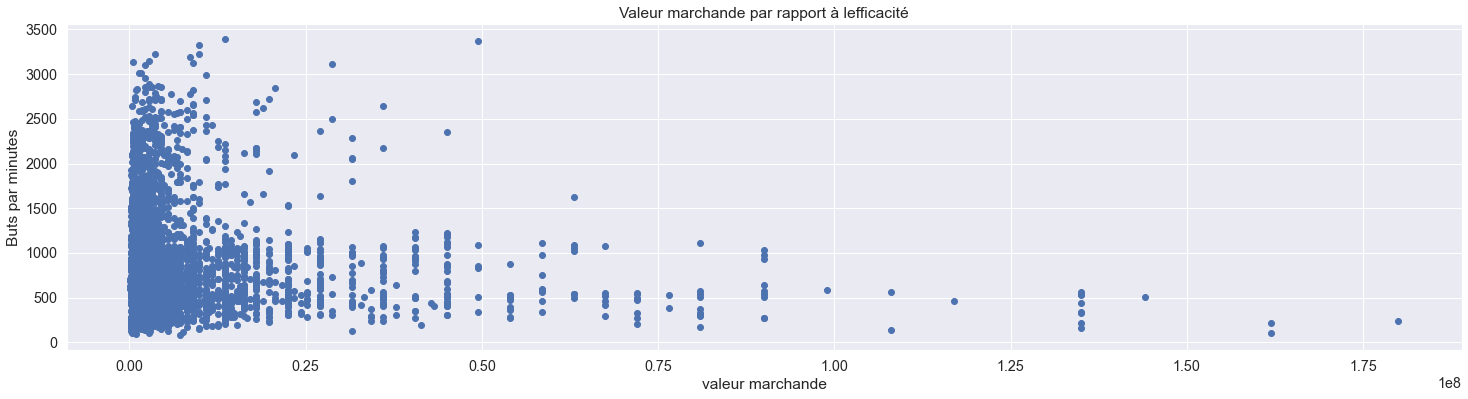

In [33]:
fig, ax = plt.subplots()
ax.scatter(x = df['valeur_marchande'], y = df['ratio buts/minute'])
plt.ylabel('Buts par minutes')
plt.xlabel('valeur marchande')
plt.title('Valeur marchande par rapport à lefficacité')
plt.show()

 ### Ici on remarque que certaines valeurs notamment celles supérieurs à 2500 semblent limié l'ajustement linéaire des variables, nous allons dons les supprimer

In [34]:
print(np.where((df['ratio buts/minute']>2500)))

(array([3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594,
       3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605,
       3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616,
       3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627,
       3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638,
       3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649,
       3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658], dtype=int32),)


### Efficacité d'un attaquant en fonction de son pied de prédilection

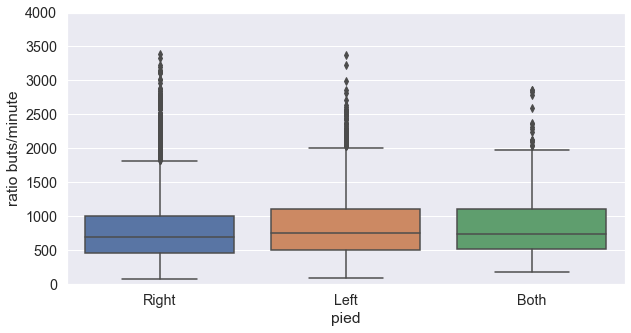

In [35]:
données = pd.concat([df['ratio buts/minute'], df['pied']], axis=1)
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x="pied", y="ratio buts/minute", data=données)
fig.axis(ymin=0, ymax=4000);

### Ici, les droitiers semblent légèrement plus efficaces, cependant, ils sont aussi plus nombreux ce qui peut impacter cette efficacité

In [36]:
df['ratio buts/minute'].describe()

count    3659.000000
mean      860.488169
std       562.861975
min        75.400000
25%       478.750000
50%       714.333333
75%      1036.000000
max      3394.000000
Name: ratio buts/minute, dtype: float64

In [37]:
df.valeur_marchande.value_counts()

2700000.0      182
1350000.0      176
1800000.0      175
900000.0       165
2250000.0      153
              ... 
10350000.0       1
99000000.0       1
117000000.0      1
518000.0         1
41400000.0       1
Name: valeur_marchande, Length: 148, dtype: int64

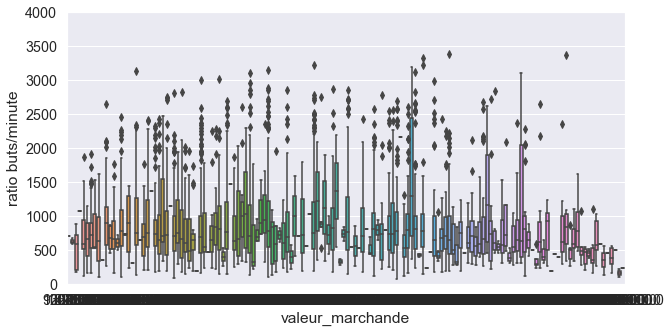

In [38]:
données = pd.concat([df['ratio buts/minute'], df['valeur_marchande']], axis=1)
f, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x="valeur_marchande", y="ratio buts/minute", data=données)
fig.axis(ymin=0, ymax=4000);

In [39]:
df['ratio buts/minute']=df['ratio buts/minute'].astype('int32')
df.head(2303)

,date_of_birth,position,minutes totales jouées,buts,passes décisives,pied,poste,championnat,valeur_marchande,taille,ratio buts/minute
player_id,,,,,,,,,,,
339314,[1996-07-19],[Attack],754,10,3,Right,Attack,BE1,7200000.0,178,75
209583,[1995-08-01],[Attack],532,6,1,Left,Attack,CGB,900000.0,178,88
85602,[1981-04-01],[Attack],598,6,1,Right,Attack,PO1,450000.0,179,99
70280,[1991-02-20],[Attack],623,6,1,Right,Attack,NL1,2700000.0,193,103
28003,[1987-06-24],[Attack],1043,10,6,Left,Attack,CDR,162000000.0,170,104
...,...,...,...,...,...,...,...,...,...,...,...
182916,[1995-04-19],[Attack],2581,3,1,Right,Attack,FR1,7200000.0,171,860
29280,[1983-06-13],[Attack],861,1,1,Right,Attack,FR1,1170000.0,187,861
29316,[1983-04-24],[Attack],2583,3,3,Right,Attack,CIT,2700000.0,189,861


In [40]:
df=df.sort_values('ratio buts/minute')
df

,date_of_birth,position,minutes totales jouées,buts,passes décisives,pied,poste,championnat,valeur_marchande,taille,ratio buts/minute
player_id,,,,,,,,,,,
339314,[1996-07-19],[Attack],754,10,3,Right,Attack,BE1,7200000.0,178,75
209583,[1995-08-01],[Attack],532,6,1,Left,Attack,CGB,900000.0,178,88
85602,[1981-04-01],[Attack],598,6,1,Right,Attack,PO1,450000.0,179,99
70280,[1991-02-20],[Attack],623,6,1,Right,Attack,NL1,2700000.0,193,103
28003,[1987-06-24],[Attack],1043,10,6,Left,Attack,CDR,162000000.0,170,104
...,...,...,...,...,...,...,...,...,...,...,...
67548,[1991-03-23],[Attack],3227,1,3,Left,Attack,CDR,3600000.0,182,3227
54245,[1987-12-14],[Attack],3228,1,3,Right,Attack,CDR,9900000.0,179,3228
215864,[1995-02-08],[Attack],3331,1,3,Right,Attack,DFB,9900000.0,175,3331


#Train and holdout
X_train_full, X_test, y_train_full, y_test = train_test_split(df[var_explicative],  
                                                    df['ratio buts/minute'])
#Train data and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
#Scaling features with different size
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [41]:
df_excel='df.xlsx'
df.to_excel(df_excel)

#### importation fichier comprenant la variable ratio buts/minutes en deux catégories

In [42]:
df_2 = pd.read_excel("C:/Users/arthu/OneDrive/Documents/M2 ECAP/SVM et réseaux de neurones/df3.xlsx")

In [43]:
bin_ratio_dummies = df_2[df_2.ratio_dummies!=1]


In [44]:
bin_ratio_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1831 entries, 0 to 3658
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   player_id               1831 non-null   int64 
 1   date_of_birth           1831 non-null   object
 2   position                1831 non-null   object
 3   minutes totales jouées  1831 non-null   int64 
 4   buts                    1831 non-null   int64 
 5   pied                    1831 non-null   object
 6   poste                   1831 non-null   object
 7   championnat             1831 non-null   object
 8   valeur_marchande        1831 non-null   int64 
 9   taille                  1831 non-null   int64 
 10  passes décisives        1831 non-null   int64 
 11  ratio buts/minute       1831 non-null   int64 
 12  ratio_dummies           1831 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 164.5+ KB


In [45]:
df_2.head()

,player_id,date_of_birth,position,minutes totales jouées,buts,pied,poste,championnat,valeur_marchande,taille,passes décisives,ratio buts/minute,ratio_dummies
0,67556,['1990-05-22'],['Attack'],1962,1,Right,Attack,CIT,1350000,199,1,1962,2
1,267614,['1997-05-10'],['Attack'],1163,1,Right,Attack,DK1,405000,198,1,1163,2
2,343769,['1997-05-21'],['Attack'],1079,1,Left,Attack,UKR1,360000,197,1,1079,2
3,314959,['1996-01-08'],['Attack'],2150,1,Right,Attack,BE1,5400000,196,1,2150,2
4,559328,['2003-02-03'],['Attack'],1100,1,Both,Attack,BE1,810000,195,0,1100,2


#### la variable à expliquer est bien équilibrée

In [46]:
df_2.ratio_dummies.value_counts()

1    1828
2     916
0     915
Name: ratio_dummies, dtype: int64

In [47]:
df_2.head()

,player_id,date_of_birth,position,minutes totales jouées,buts,pied,poste,championnat,valeur_marchande,taille,passes décisives,ratio buts/minute,ratio_dummies
0,67556,['1990-05-22'],['Attack'],1962,1,Right,Attack,CIT,1350000,199,1,1962,2
1,267614,['1997-05-10'],['Attack'],1163,1,Right,Attack,DK1,405000,198,1,1163,2
2,343769,['1997-05-21'],['Attack'],1079,1,Left,Attack,UKR1,360000,197,1,1079,2
3,314959,['1996-01-08'],['Attack'],2150,1,Right,Attack,BE1,5400000,196,1,2150,2
4,559328,['2003-02-03'],['Attack'],1100,1,Both,Attack,BE1,810000,195,0,1100,2


In [48]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   player_id               3659 non-null   int64 
 1   date_of_birth           3659 non-null   object
 2   position                3659 non-null   object
 3   minutes totales jouées  3659 non-null   int64 
 4   buts                    3659 non-null   int64 
 5   pied                    3659 non-null   object
 6   poste                   3659 non-null   object
 7   championnat             3659 non-null   object
 8   valeur_marchande        3659 non-null   int64 
 9   taille                  3659 non-null   int64 
 10  passes décisives        3659 non-null   int64 
 11  ratio buts/minute       3659 non-null   int64 
 12  ratio_dummies           3659 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 300.2+ KB


In [49]:
colnames = {'valeur_marchande':'integer','taille':"integer",'passes décisives':"integer"}

In [50]:
var_explicative = list(colnames.keys())


In [51]:
#Modélisation 
#Classifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC 
from sklearn.linear_model import SGDClassifier , LogisticRegression
#Multiclass strategie
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
#Regressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
#Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#Eval
from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV


In [52]:
from sklearn.model_selection import train_test_split


In [53]:
X_train , X_test, y_train, y_test = train_test_split(bin_ratio_dummies.iloc[:,8:11],  
                                                    bin_ratio_dummies['ratio_dummies'], 
                                                    test_size=0.2 ,
                                                    shuffle=True ,
                                                    random_state=42
                                                   )


In [54]:
y_train.describe()

count    1464.000000
mean        1.008197
std         1.000308
min         0.000000
25%         0.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: ratio_dummies, dtype: float64

In [55]:
X_train.describe()

,valeur_marchande,taille,passes décisives
count,1.464000e+03,1464.000000,1464.000000
mean,7.643151e+06,180.343579,1.783470
std,1.585584e+07,6.643761,1.272336
min,1.800000e+05,161.000000,0.000000
25%,9.000000e+05,175.000000,1.000000
50%,2.700000e+06,180.000000,1.000000
75%,6.750000e+06,185.000000,3.000000
max,1.800000e+08,200.000000,7.000000


In [56]:
y_test.describe()

count    367.000000
mean       0.970027
std        1.000915
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        2.000000
Name: ratio_dummies, dtype: float64

In [57]:
from sklearn.preprocessing import StandardScaler

In [58]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [59]:
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [60]:

class_svc = SVC(random_state=42, kernel='linear')
class_svc.fit(X_train_sc, y_train)

SVC(kernel='linear', random_state=42)

### Classification

In [61]:
%matplotlib inline

In [62]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):

    
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

 
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

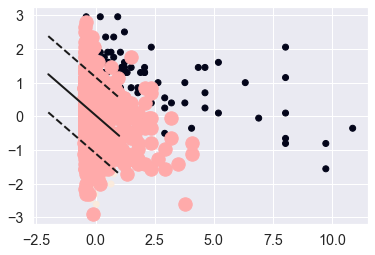

In [63]:
plt.scatter(X_train_sc[:,0], X_train_sc[:,1], c=y_train)
plot_svc_decision_boundary(class_svc, -2, 1)

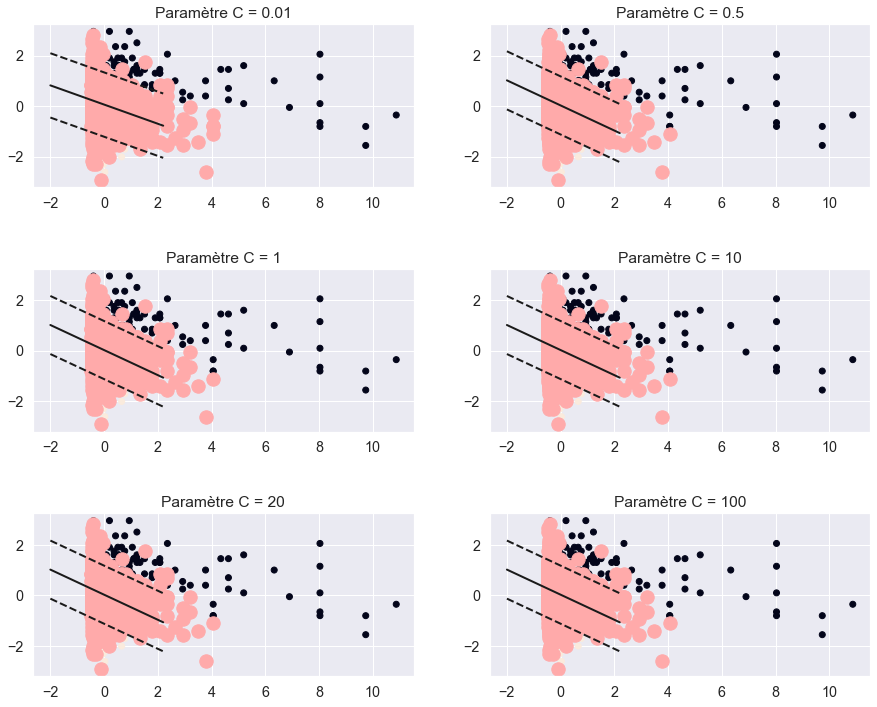

In [64]:
C = [0.01,0.5,1,10,20,100]
#Taille image et subplot 
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)


for i,j  in enumerate(C):
    #Train
    class_svc = SVC(C=j , random_state=42 , kernel='linear')
    class_svc.fit(X_train_sc[:,0:2], y_train)
    ax = plt.subplot(3, 2, i + 1)
    #Plot
    plt.scatter(X_train_sc[:,0], 
               X_train_sc[:,1], 
                c=y_train
               )
    plot_svc_decision_boundary(class_svc, -2, 2.2)
    plt.title('Paramètre C = '+str(j))


### la frontière de décision est assez mal représentée malgré les variations du paramètre de régularisation, nous allons chercher à modèliser notre jeu de donnée 

### Entrainement des 4 modèles sur le dataset d'entrainement
#### LogisticRegression
#### LinearSVC
#### SVC
#### SGDClassifier

In [65]:
#Regression logistique
lgr = LogisticRegression( random_state=42)
lgr.fit(X_train_sc, y_train)

#Linear SVM
l_SVC = LinearSVC(random_state=42, max_iter=2000)
l_SVC.fit(X_train_sc, y_train)

#SVM avec kernel
svc = SVC(kernel='linear',random_state=42)
svc.fit(X_train_sc,y_train)

#SGD classifier
sgdc_svm = SGDClassifier(loss='hinge' ,random_state=42)
sgdc_svm.fit(X_train_sc, y_train)

SGDClassifier(random_state=42)

In [66]:
#cross validation
cvs_lgr = cross_val_score(lgr, X_train_sc, y_train, cv=5, scoring='accuracy')

cvs_lsvc = cross_val_score(l_SVC, X_train_sc, y_train, cv=5, scoring='accuracy')

cvs_svc = cross_val_score(svc, X_train_sc, y_train, cv=5, scoring='accuracy')

cvs_sgdc = cross_val_score(sgdc_svm, X_train_sc, y_train, cv=5, scoring='accuracy')

In [67]:
#Get data output from cross_val_score
df_cross = pd.DataFrame(np.transpose(np.c_[cvs_lgr,cvs_lsvc,cvs_sgdc,cvs_svc]), 
                        columns=['fold1','fold2','fold3','fold4','fold5'])
#Adding model label
df_cross['model'] = ['lgr','lsvc','sgdc','svc']

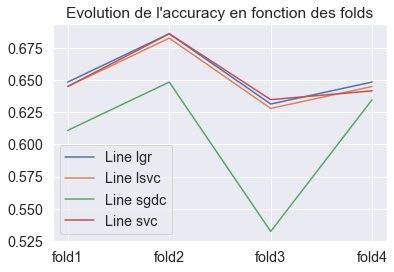

In [68]:
#Regardons l'évolution des scores pour chaque fold
for row in range(df_cross.shape[0]):
    plt.plot( df_cross.iloc[row,0:4] ,label='Line '+str(df_cross.iloc[row,5]))

plt.legend()
plt.title("Evolution de l'accuracy en fonction des folds")
plt.show()

In [69]:
df_cross.head(5)

,fold1,fold2,fold3,fold4,fold5,model
0,0.648464,0.686007,0.631399,0.648464,0.660959,lgr
1,0.645051,0.682594,0.627986,0.645051,0.660959,lsvc
2,0.610922,0.648464,0.532423,0.634812,0.650685,sgdc
3,0.645051,0.686007,0.634812,0.641638,0.657534,svc


In [70]:
for i in range(4):

    mean_model = df_cross.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross.iloc[:,0:5].std(axis=1)[i]
    
    print('Le modèle N° '+ str(i) + ' a une accuray de '  + str(mean_model) + ' et un std' +str(std_model))

Le modèle N° 0 a une accuray de 0.6550586750198699 et un std0.020244388772914297
Le modèle N° 1 a une accuray de 0.6523282995932489 et un std0.02054832350773095
Le modèle N° 2 a une accuray de 0.6154612183832812 et un std0.04904153439342007
Le modèle N° 3 a une accuray de 0.6530085557997101 et un std0.020205667110930938


## Choix du modèle
### On prend le modèle linear SVC comme modèle final. Il est celui qui a le meilleur score en moyenne sur les folds 65% de bonnes prédictions. Il s'agit d'un modèle qui offre beaucoup plus d'hyperparamètres, il nécessite beaucoup de tunage avant d'offrir des bonnes performances.

### De plus le modèle régression logistique est celui qui a le moins de variance entre les scores de ses folds 0.020 de std. Le modèle semble stable et donc il possède moins de chance d'être en under ou overfitting.

### Les résultats étant très proches pour nos 4 modèles nous allons effectuer un grid search sur le modèle SVC linear pour avoir un compromis entre une faible variance et de bonnes prédictions

#### Obtention des hyperparamètres 

In [71]:

SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

#### on choisit la méthode ainsi que le paramètre de tolérance

In [72]:
params = {
    "kernel" : ["linear"],
    "C" : [0.5, 1, 10, 50,100,1000]
        }

c_svc = SVC(random_state=42)

In [73]:
grid_c_svc = GridSearchCV(c_svc, param_grid=params, cv=5, return_train_score=True)

In [74]:
take_grid = grid_c_svc.fit(X_train_sc, y_train)
take_grid.cv_results_


{'mean_fit_time': array([0.0374033 , 0.03140244, 0.09620728, 0.26142077, 0.40663056,
        4.0663054 ]),
 'std_fit_time': array([6.24814833e-03, 2.65361792e-03, 1.53025407e-02, 1.46779247e-02,
        3.11247335e-02, 3.16161413e+00]),
 'mean_score_time': array([0.00380058, 0.00320067, 0.00400043, 0.00399885, 0.00480061,
        0.00400071]),
 'std_score_time': array([0.00074883, 0.00074867, 0.0012661 , 0.00109563, 0.00132749,
        0.00089378]),
 'param_C': masked_array(data=[0.5, 1, 10, 50, 100, 1000],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'linear', 'linear', 'linear', 'linear',
                    'linear'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.5, 'kernel': 'linear'},
  {'C': 1, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'linear'},
  {'C': 50, 'kernel': 'linear'}

In [75]:
print("La meilleur combinaison d'estimateur est: " + str(take_grid.best_params_)+"\n"
      "pour un score de: " + str(take_grid.best_score_))

La meilleur combinaison d'estimateur est: {'C': 10, 'kernel': 'linear'}
pour un score de: 0.6536934873065594


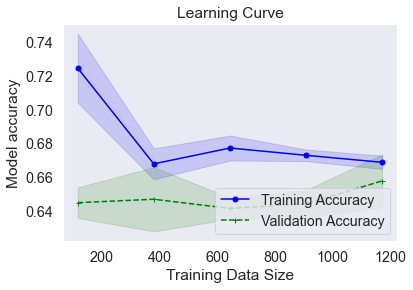

In [76]:
train_sizes, train_scores, test_scores = learning_curve(estimator=c_svc, 
                                                        X=X_train_sc, 
                                                        y=y_train,
                                                        cv=5, 
                                                        train_sizes=np.linspace(0.1, 1.0, 5),
                                                        random_state=42
                                                       )


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

## Entrainement du modèle sur les hyperparamètres avec la meilleur performance

In [77]:
take_grid.best_params_


{'C': 10, 'kernel': 'linear'}

In [78]:
best_svc = SVC(C=0.5, kernel='linear')


In [79]:
best_svc.fit(X_train_sc, y_train)


SVC(C=0.5, kernel='linear')

<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 216x144 with 0 Axes>

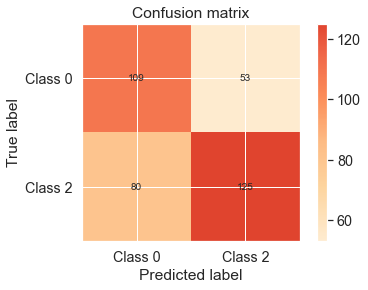

In [80]:
plt.figure(figsize=(3,2))
plot.confusion_matrix(best_svc.predict(X_test_sc), y_test)

#### Les faux positifs et faux négatifs sont de 80 et 53 erreurs de chaque.

## Prédiction avec le meilleur modèle

### Performance du modèle

In [81]:
print('Training score: ' + str(best_svc.score(X_train_sc,y_train)), 
      '\n',
      'Test score: ' + str(best_svc.score(X_test_sc, y_test))
     )

Training score: 0.6523224043715847 
 Test score: 0.6376021798365122


### Avec un training score de 65.2% et un test score de 63.7%, les résultats semblent satisfaisants et nous ne suspections pas de problèmes apparents

## Influence des paramètres sur le modèle

In [82]:
def svm_f_importances(coef_svm , names):
    ''' 
    Cette fonction permet de visualiser l'importance de chaque variable pour le modèle SVM
    Vous devez passer 2 arguments :
    
    - coef_svm : Les coéfficients du modèle disponible après votre .fit()
      On le récupère avec la commande suite  svc_fit.coef_[0]
      
    - names : est le nom des features que vous avez utilisée.
      ATTENTION à passer dans le même ordre que pour l'entrainement du modèle
    
    '''
    imp = coef_svm
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

#features_names = ['input1', 'input2']
#svm = svm.SVC(kernel='linear')
#svm.fit(X, Y)
#f_importances(svm.coef_[0], features_names)

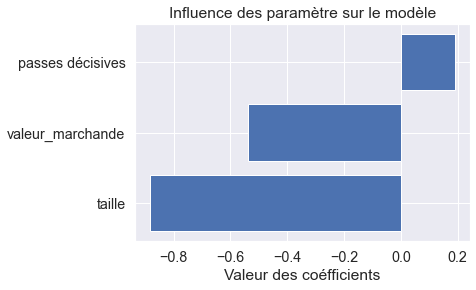

In [83]:
plt.title('Influence des paramètre sur le modèle')
plt.xlabel('Valeur des coéfficients')
svm_f_importances(best_svc.coef_[0], var_explicative)